In [1]:
%pylab inline
import matplotlib.pyplot as plt

import sys
import os
import numpy as np
import seaborn as sns
import sklearn.metrics

# local imports
import sim_fxns as sim
sys.path.append("../scripts")
import plot_utils
import unsharpening_matrices as um

save_fig = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set up plotting environment
save_dir = "../figs_output/simulations"

# define colors
scatter_cmap = sns.cubehelix_palette(8, start=.5,light=0.7, rot=-.75,as_cmap=True)

# 1d linear example

In [3]:
plot_utils.reset()

def scale(x):
    return (x/n).reshape(-1,1)

def ident(x):
    return x.reshape(-1,1)

def zero(x):
    return np.zeros((x.shape[0],1))

n = 2000


v = np.arange(n)
t = scale(v)
D = um.distance_matrix(t.reshape(-1,1))
sigma = 0.2
cov_Z = 1e0*np.exp(-D / (2*sigma**2))

c = 1
    
sigmas = np.logspace(-4,0, base=10, num=20)
c1s = np.linspace(0,1,num=11)
# don't shrink
c2s = [1]

num_trials = 10

sigma_pairs = [[0.1,0.1],
               [0.2,0.1],
               [0.4,0.1],
               [0.1,0.2],
               [0.2,0.2],
               [0.4,0.2],
               [0.1,0.4], 
               [0.2,0.4], 
               [0.4,0.4]
] 

mses_smoothed = np.zeros((len(sigma_pairs),num_trials))
mses_unsmoothed = np.zeros((len(sigma_pairs),num_trials))
mses_w_star = np.zeros((len(sigma_pairs),num_trials))

c_ests  = np.zeros((len(sigma_pairs),num_trials)) 

verbose = False 

# loop over noise settings in x and y
for j, (sigma_x, sigma_y) in enumerate(sigma_pairs):
    print()
    print(j, end=": ")
    # repeat for each trial
    for i in range(num_trials):
        print("    ",i, end="")

        setup_vars = sim.setup_vars_simple(n, sigma_x, sigma_y, cov_Z, 
                               z_mean_function=ident, a=1,
                               random_state = i)
        # standard solve
        results = sim.split_and_predict(setup_vars, val_pct=0.5, add_intercept=False, use_tls=True)
        r2_baseline_train, r2_baseline_val = sim.unsmoothed_performance(setup_vars, results)
        c_ests[j,i] =results['w_hat']
        
        #smoothing
        results_smoothed = sim.performance_by_sigmas(setup_vars, results, t.reshape(-1,1), sigmas, 
                                                 c1s, c2s)
        # unpack the performance results
        smoothed_performance = sim.read_smoothed_performance(results_smoothed)
        r2s_train, r2s_val = results_smoothed['r2s_train_smoothed'], results_smoothed['r2s_val_smoothed']
        
        # get the best smoothed predictor
        c1_val, c2_val, sigma_val = smoothed_performance['best_c1_val'], smoothed_performance['best_c2_val'], smoothed_performance['best_sigma_val']
        if verbose:
            print('sigma: is {0}, c1_chosen is {1}, c2_chosen is {2} '.format(sigma_val,c1_val,c2_val))

        
        preds_dict = sim.make_preds_dict(setup_vars, results, smoothed_performance)
        vars_dict = {"noise_scale_x": sigma_x, "noise_scale_y": sigma_y}

        mses_smoothed[j,i] = sim.read_mse_smoothed(preds_dict)
        mses_unsmoothed[j,i] = sim.read_mse_unsmoothed(preds_dict)

    
        # record the result using the optimal W* from theoretical analysis
        smoothed_star= sim.smooth_with_W_star(setup_vars, results)
        theoretical_optimal = sklearn.metrics.mean_squared_error(results['y_val'],smoothed_star)
        mses_w_star[j,i] = theoretical_optimal
    



0:      0     1     2     3     4     5     6     7     8     9
1:      0     1     2     3     4     5     6     7     8     9
2:      0     1     2     3     4     5     6     7     8     9
3:      0     1     2     3     4     5     6     7     8     9
4:      0     1     2     3     4     5     6     7     8     9
5:      0     1     2     3     4     5     6     7     8     9
6:      0     1     2     3     4     5     6     7     8     9
7:      0     1     2     3     4     5     6     7     8     9
8:      0     1     2     3     4     5     6     7     8     9

# Plot the results

/Users/estherrolf/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4269: MatplotlibDeprecationWarning: 
The 'verts' kwarg was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use 'marker' instead.
  alternative="'marker'")


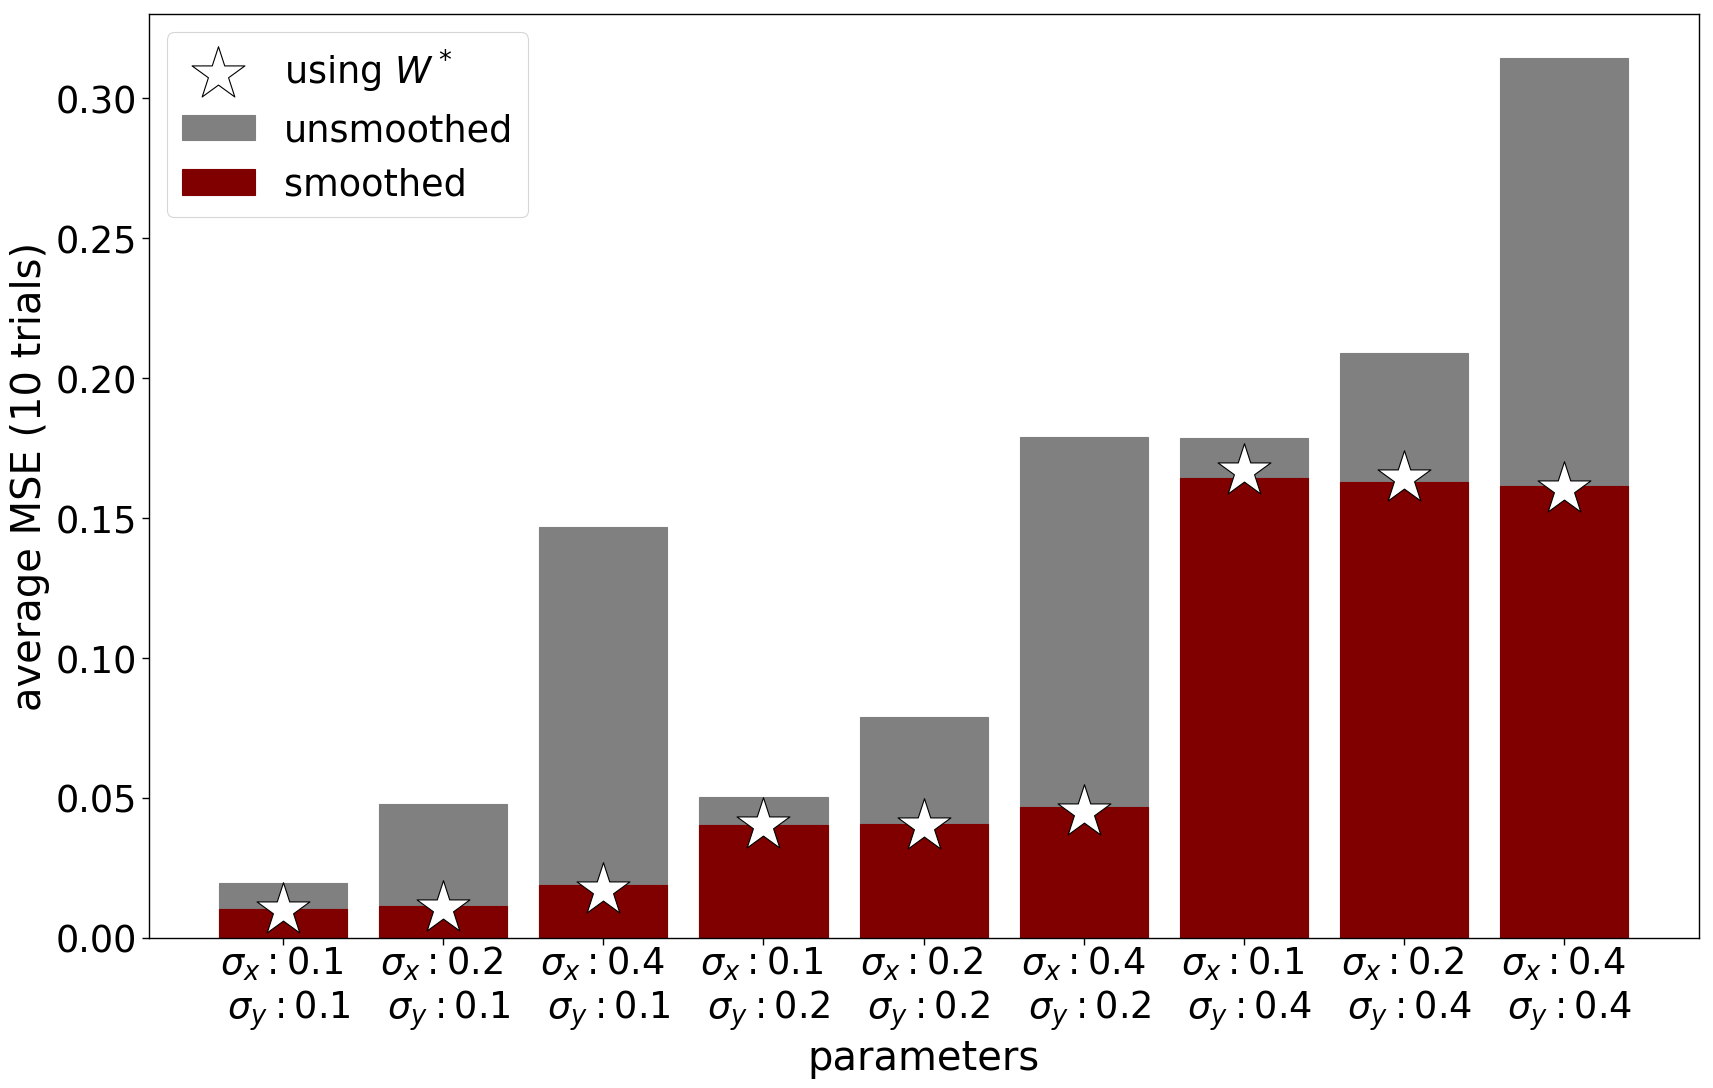

In [4]:
a = 1
mses_expected_unsmoothed =  [a**2*sigma_x**2 + sigma_y**2 for i,(sigma_x, sigma_y)  in enumerate(sigma_pairs)]

usmoothed_mean = np.average(mses_unsmoothed,axis=1)
usmoothed_max_delta = np.max(mses_unsmoothed,axis=1)- usmoothed_mean
usmoothed_min_delta =  usmoothed_mean - np.min(mses_unsmoothed,axis=1)
unsmoothed_yerr = np.vstack((usmoothed_min_delta,usmoothed_max_delta))
unsmoothed_yerr.shape

smoothed_mean = np.average(mses_smoothed,axis=1)
smoothed_max_delta = np.max(mses_smoothed,axis=1)-smoothed_mean
smoothed_min_delta =  smoothed_mean - np.min(mses_smoothed,axis=1)
smoothed_yerr = np.vstack((smoothed_min_delta,smoothed_max_delta))
smoothed_yerr.shape

wstar_mean = np.average(mses_w_star,axis=1)
wstar_max_delta = np.max(mses_w_star,axis=1)-wstar_mean
wstar_min_delta =  wstar_mean - np.min(mses_w_star,axis=1)
wstar_yerr = np.vstack((wstar_min_delta,wstar_max_delta))
wstar_yerr.shape

matplotlib.rcParams.update({'font.size': 40,  'legend.fontsize':30})
sns.set_context('paper',font_scale=3)

fig, ax = plt.subplots(figsize=(20,12))
anchors = np.arange(len(sigma_pairs))
ax.bar(anchors,np.average(mses_unsmoothed,axis=1),
       color='grey', edgecolor='grey', label='unsmoothed')
ax.bar(anchors,np.average(mses_smoothed,axis=1), 
       color='maroon', edgecolor='maroon',label='smoothed')

anchors_star = anchors

ax.scatter(anchors_star,np.average(mses_w_star,axis=1), verts=wstar_yerr,
           marker='*',s=1600,color="white",
            edgecolor="black", zorder=2, label='using $W^*$')


ax.set_ylim(0)

ax.set_xticks(anchors)
sigma_pair_labels = ["$\sigma_x: {0}$ \n $\sigma_y: {1}$".format(sigma_x, sigma_y) for (sigma_x, sigma_y)  in sigma_pairs]
ax.set_xticklabels(sigma_pair_labels)

ax.legend()
ax.set_ylabel("average MSE (10 trials)")
ax.set_xlabel("parameters")
plt.show()
if save_fig:
    plt.savefig(os.path.join(save_dir, "plot_with_stars.pdf"),bbox_inches='tight')

# Show smoothing process fpr two distributional settings

sigma: is 0.0206913808111479, c1_chosen is 1.0, c2_chosen is 1 
lower bound is 0.0005
ours is 0.0007
expected without smoothing is 0.0401
sigma: is 0.0206913808111479, c1_chosen is 1.0, c2_chosen is 1 
lower bound is 0.0114
ours is 0.0169
expected without smoothing is 0.1700


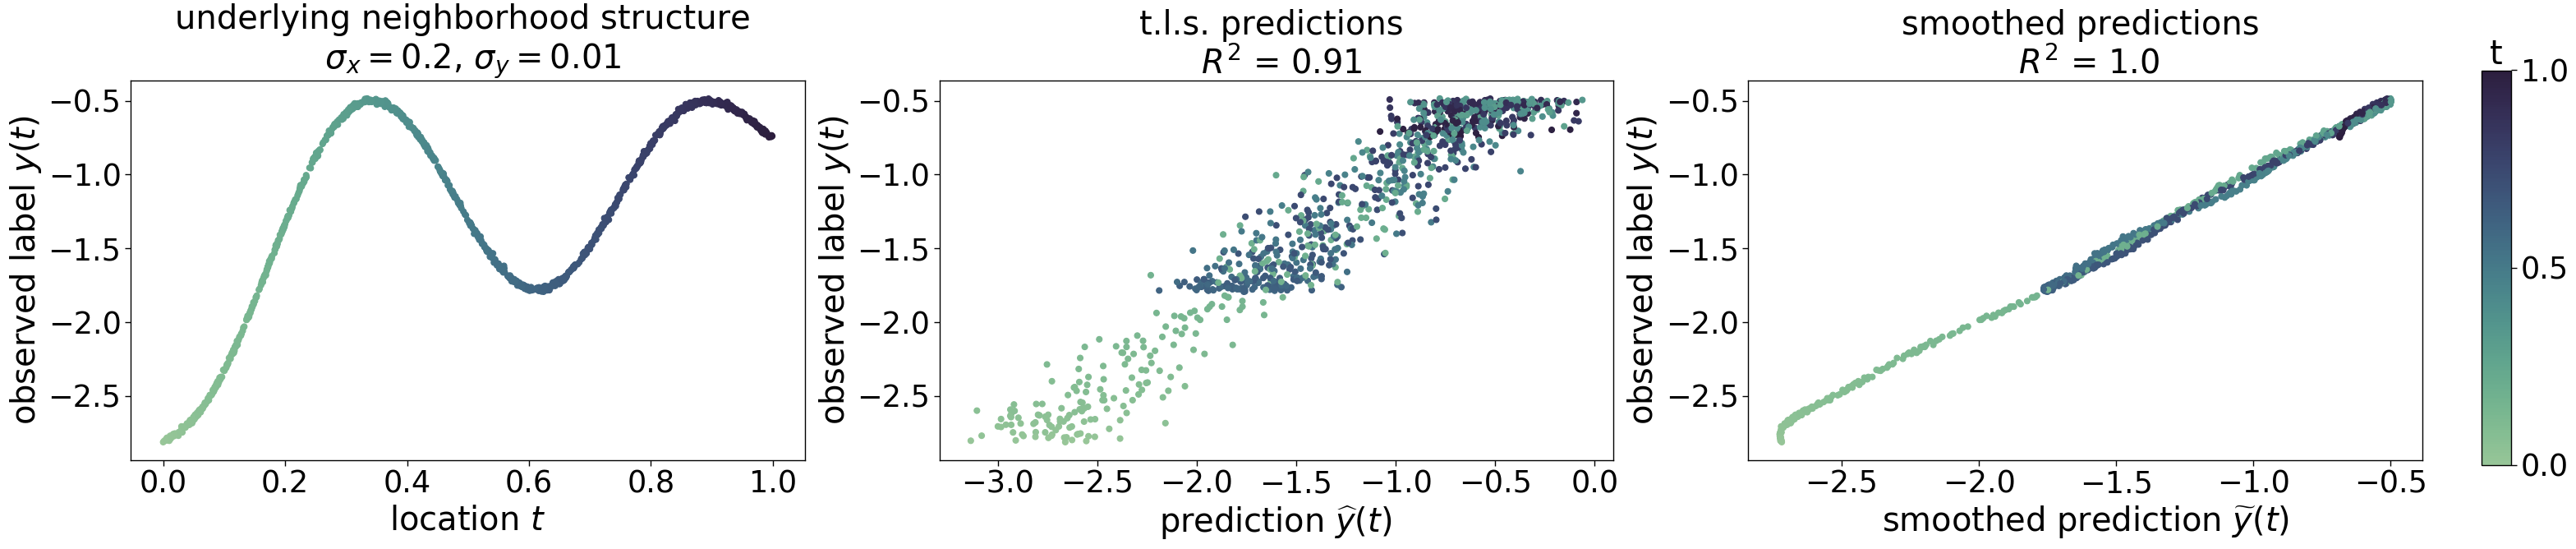

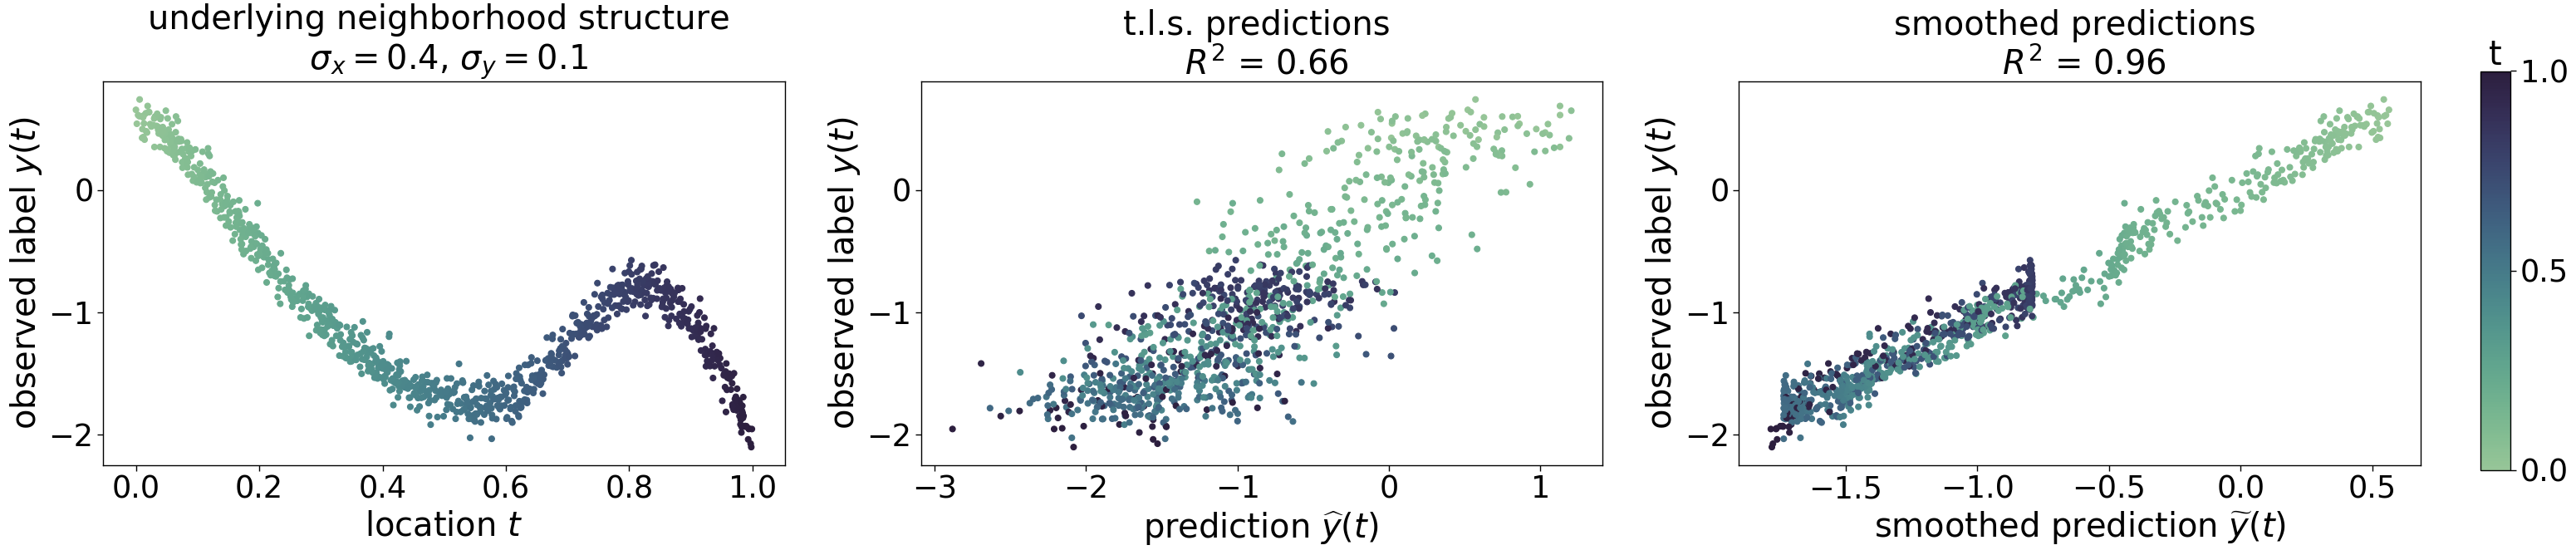

In [5]:
num_trials = 1

preds_dicts = []

vars_dicts = []
sigma_pairs_fewer = [[0.2,0.01],
                     [0.4,0.1]]


for j, (sigma_x, sigma_y) in enumerate(sigma_pairs_fewer):
    for i in range(num_trials):
        setup_vars = sim.setup_vars_simple(n, sigma_x, sigma_y, cov_Z, 
                               z_mean_function=zero, a=1,
                               random_state = j)
        # standard solve
        results = sim.split_and_predict(setup_vars, val_pct=0.5, add_intercept=False, use_tls=True)
        r2_baseline_train, r2_baseline_val = sim.unsmoothed_performance(setup_vars, results)

        #smoothing
        results_smoothed = sim.performance_by_sigmas(setup_vars, results, t.reshape(-1,1), sigmas, 
                                                 c1s, c2s)
        smoothed_performance = sim.read_smoothed_performance(results_smoothed)
        r2s_train, r2s_val = results_smoothed['r2s_train_smoothed'], results_smoothed['r2s_val_smoothed']
        # get the best smoothed predictor
        c1_val, c2_val, sigma_val = smoothed_performance['best_c1_val'], smoothed_performance['best_c2_val'], smoothed_performance['best_sigma_val']
        print('sigma: is {0}, c1_chosen is {1}, c2_chosen is {2} '.format(sigma_val,c1_val,c2_val))

    
        preds_dict = sim.make_preds_dict(setup_vars, results, smoothed_performance)
        preds_dicts.append(preds_dict)
        vars_dict = {"noise_scale_x": sigma_x, "noise_scale_y": sigma_y}
        vars_dicts.append(vars_dict)
        mses_smoothed[j,i] = sim.read_mse_smoothed(preds_dict)
        mses_unsmoothed[j,i] = sim.read_mse_unsmoothed(preds_dict)
        
        # plot results
        mse_smoothed = sim.plot_fancy_scatter(preds_dict, vars_dict,s=25, cmap=scatter_cmap, predictor="t.l.s.")
    
        smoothed_star= sim.smooth_with_W_star(setup_vars, results)
        theoretical_optimal = sklearn.metrics.mean_squared_error(results['y_val'],smoothed_star)
        mses_w_star[j,i] = theoretical_optimal
    
        print("lower bound is {0:.4f}".format(sim.compute_expectation_lower_bound(setup_vars, 
                                                                              results, compute_alpha = True)))
        print("ours is {0:.4f}".format(mse_smoothed))
    
        print("expected without smoothing is {0:.4f}".format(sim.compute_expectation_unsmoothed(setup_vars, 
                                                                                     results,compute_alpha=False)))

plt.show()
if save_fig:
    save_file = os.path.join(save_dir, "sim_sigmax_{0}_sigmay_{1}_n_{2}_rs_{3}.pdf".format(
                                                                   sigma_x, sigma_y, n, j))
    plt.savefig(save_file, bbox_inches='tight')

# View performance of smoothed vs. unsmoothed over the trials
# performance of optimal given by black outlines

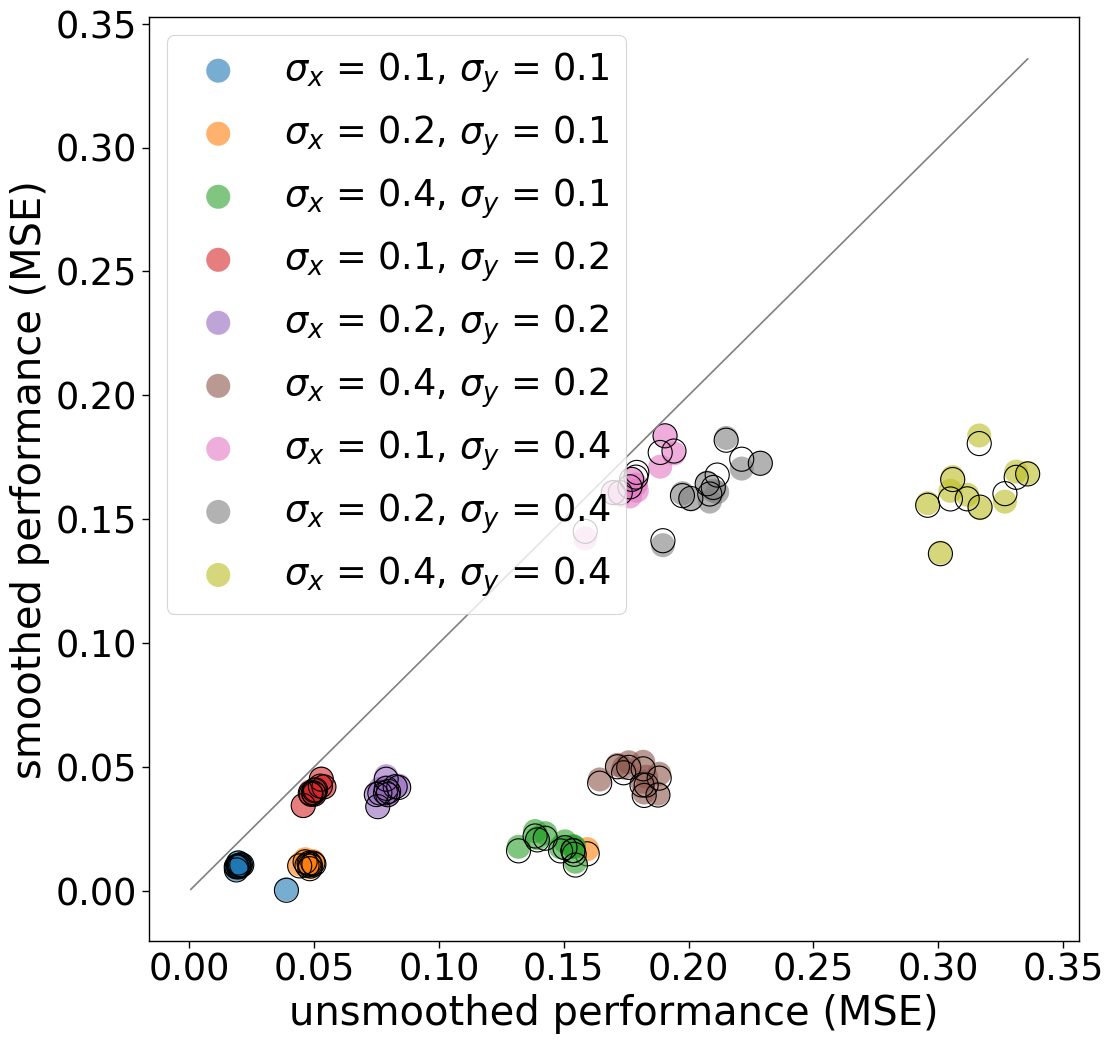

In [6]:
fig, ax = plt.subplots(figsize=(12,12))

# set up 1-1 line
max_val = np.max(np.hstack((mses_unsmoothed,mses_smoothed)))
min_val = np.min(np.hstack((mses_unsmoothed,mses_smoothed)))
ax.plot([min_val, max_val], [min_val,max_val], color="grey")#, label = "1-1 line")

# # use default seaborn color palette
colors = sns.color_palette()

for j, sigma_pair in enumerate(sigma_pairs):
    # add scatter  
    ax.scatter(mses_unsmoothed[j,:], mses_smoothed[j,:], 
               label="$\sigma_x$ = {0}, $\sigma_y$ = {1}".format(sigma_pair[0], sigma_pair[1]), 
               c=[colors[j] for i in range(mses_unsmoothed.shape[1])],
               s = 300, alpha=0.6,edgecolors='none')
    ax.scatter(mses_unsmoothed[j,:], mses_w_star[j,:], c='none',s = 300,edgecolors='black')

ax.set_xlabel("unsmoothed performance (MSE)")
ax.set_ylabel("smoothed performance (MSE)")
ax.legend()

plt.show()